In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import datetime

from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import time
pd.set_option('max_colwidth',400)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.utils.data
import random
import warnings
warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples.")
import re

Using TensorFlow backend.


In [0]:
torch.cuda.is_available()

True

CuDNN's implementation of GRU and LSTM is much faster than the regular implementation but they do not run deterministically in TensorFlow and Keras. In this competition were speed is essential you can not afford to keep determinism by using the regular implementation of GRU and LSTM.


**PyTorch to the rescue!**
In PyTorch, CuDNN determinism is a one-liner: torch.backends.cudnn.deterministic = True. This already solves the problem everyone has had so far with Keras. But that's not the only advantage of PyTorch. PyTorch is:

1. Significantly faster than Keras and TensorFlow. Again, speed is important in this competition so this is great.
2. has a more pythonic API. Inn TensorFlow there are seemingly tens of thousands of ways to do simple things. PyTorch has (in most cases) one obvious way and is by far not as convoluted as TensorFlow.
3. Eager execution. There is no such thing as an execution graph in PyTorch. That makes it much easier to try new things and interact with PyTorch in a notebook.

Keras solves some of these problems with TensorFlow but it has a high-level API. I think that when doing research, it is often preferable to be able to interact with the model on a low-level. And you will see that the lower level API still doesn't make it complicated to work with PyTorch.

**`seed_torch`** sets the seed for numpy and torch to make sure functions with a random component behave deterministically.

**`torch.backends.cudnn.deterministic = true`** sets the CuDNN to deterministic mode.

This function allows us to run experiments 100% deterministically.

In [0]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    ### maintains CuDNN determinism

In [0]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
sub = pd.read_csv('../input/sample_submission.csv')

### Data overview

This is a kernel competition, where we can't use external data. As a result we can use only train and test datasets as well as embeddings which were provided by organizers.

In [0]:
import os
print('Available embeddings:', os.listdir("../input/embeddings/"))

Available embeddings: ['paragram_300_sl999', 'glove.840B.300d', 'wiki-news-300d-1M', 'GoogleNews-vectors-negative300']


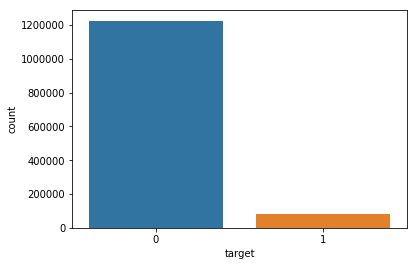

In [0]:
sns.countplot(train['target'])

In [0]:
train["target"].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [0]:
print(len(train.question_text[train['target'] == 0]) / len(train['question_text']) * 100,'percent of sincere')
print(len(train.question_text[train['target'] == 1]) / len(train['question_text']) * 100,'percent of insincere')

93.81298224821265 percent of sincere
6.187017751787352 percent of insincere


### Evaluation method and Validation techniques

**We have a seriuos disbalance - only ~6% of data are positive.**


And it is quite a natural trend for these kind of tasks. We will expect to have very few malicious / insincere / obscure questions. Here positive means sort of
insincere question which will probably collapse on Quora platform and negative means a normal question. 

Usually in unbalanced datasets, F1-score is considered as a good metric to go to.

**The F1 Score is defined as**  `2` `x` (`precision` `x` `recall`)`/`(`precision` `+` `recall`)

It is also called the F Score or the F Measure. 
Put another way, the F1 score conveys the balance between the precision and the recall. So what is precision and recall??

**Precision** =`True Positives` `/` (`True Positives` + `False Positives`). 

In other words, it is the number of positive predictions divided by the total number of positive class values predicted.

**Recall** =`True Positives``/`(`True Positives` `+` `False Negatives`). 

In other words, it is the number of positive predictions divided by the number of positive class values in the test data.

**When we have less positive examples in our dataset we need to use precision and recall because the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem)**.

So for our problem, F1-score is a preferable metric.

**Cross-validation procedure:**

A common practice in datascience competitons is to iterate over various models to find a better performing model. However, it becomes difficult to distinguish whether any improvement in score is coming because we are capturing relationship better or we are just overfitting the data. To find the right answer to this question, we use validation techniques which helps in achieving more generalized relationships.
Cross-validation is a statistical method used to estimate the skill of machine learning models. It helps in comparing models to assure lower bias and variance

There are various types of cross-validation. One type is the **`K-fold cross-validation`** which we will use here. 

In this type, the data set is partitioned into **`K`** equal sized sets where one set is used for testing and the rest of the partitions are used for training. This enables us to run **`K`** different runs, where each partition is once used as a testing set. 

So, higher the **`K`** ,  more accurate the model evaluation is, but the smaller each testing set is.

Particularly, since we have imbalanced data here, we will be using **`Stratified K-fold cross validation`**. 

Here each fold contains approximately the same percentage of samples for each target class as the complete set.



In [0]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


### Common pre-processing for text data

In principle, our preprocessing should match the preprocessing that was used before training the pre-trained word embedding. Since most of the embeddings don’t provide vector values for punctuations and other special chars, the first thing you want to do is to get rid of the special characters in your text data. Look at the function *clean_text(x)*. It accomplishes the necessary cleaning task.

Why do we want to replace numbers with #s? Because most embeddings have preprocessed their text like this. Check out *clean_numbers(x)*.

Contractions are words that we write with an apostrophe. Examples of contractions are words like “ain’t” or “aren’t”. Since we want to standardize our text, it makes sense to expand these contractions. Below we have done this using a contraction mapping and regex functions. Check out  *_get_mispell* and *replace_typical_misspell* functions..



In [0]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

train["question_text"] = train["question_text"].apply(lambda x: x.lower())
test["question_text"] = test["question_text"].apply(lambda x: x.lower())

# Clean the text
train["question_text"] = train["question_text"].apply(lambda x: clean_text(x))
test["question_text"] = test["question_text"].apply(lambda x: clean_text(x))

# Clean numbers
train["question_text"] = train["question_text"].apply(lambda x: clean_numbers(x))
test["question_text"] = test["question_text"].apply(lambda x: clean_numbers(x))

# Clean speelings
train["question_text"] = train["question_text"].apply(lambda x: replace_typical_misspell(x))
test["question_text"] = test["question_text"].apply(lambda x: replace_typical_misspell(x))

### Representation of text string by a list of integer numbers

One of the things that have made Deep Learning the go to choice for NLP is the fact that we don’t really have to hand-engineer features from the text data. 

The deep learning algorithms take as input a sequence of text to learn the structure of text just like a human does. Since Machine cannot understand words they expect their data in numerical form. So we would like to represent out text data as a series of numbers.

To understand how this is done we need to understand a little about the **`Keras Tokenizer`** function. One can use any other tokenizer also. Here we will be using Keras `Tokenizer`.

The `num_words parameter` keeps a pre-specified number of words in the text only. This is helpful as we don’t want our models to get a lot of noise by considering words that occur very infrequently. In real-world data, most of the words we leave using num_words parameter are normally misspells. The tokenizer also filters some non-wanted tokens by default and converts the text into lowercase.

The tokenizer once fitted to the data also keeps an index of words (dictionary of words which we can use to assign a unique number to a word) which can be accessed by `tokenizer.word_index`. The words in the indexed dictionary are ranked in order of frequencies.

Normally our model expects that each sequence (each training example) will be of the same length (same number of words/tokens) so that we can process the training samples in batches. We can control this using the `maxlen` parameter in Keras `pad_sequences`.


In [0]:
max_features = 120000
tk = Tokenizer(lower = True, filters='', num_words=max_features)

### we will make a list of questions from training data as well as test data together as "full_text" and 
### perform tokenizer fitting on "full_text" 

full_text = list(train['question_text'].values) + list(test['question_text'].values)
tk.fit_on_texts(full_text)

In [0]:
train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test['question_text'].fillna('missing'))

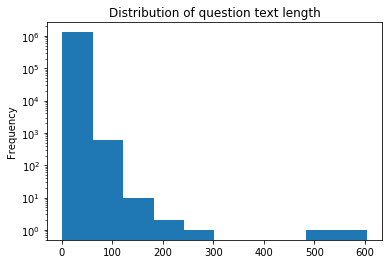

In [0]:
train['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length');

How do you know what is the best "maxlen" to set? If you put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.

One of the ways to go about it is to see the distribution of the number of words in sentences.

We can see that most of the questions are 40 words long or shorter. Let's try having sequence length equal to 72 for now.

In [0]:
max_len = 72
maxlen = 72
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [0]:
y_train = train['target'].values

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Let's define **4-Fold cross-validation**. The *random_state* here is important to make sure this is deterministic too.

**cross-validation splits training data into "train" and "validation" sets**

In [0]:
from sklearn.model_selection import StratifiedKFold
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=10).split(X_train, y_train)) ### Generate indices to split data into training and validation/test set.

### Word embeddings and the importance of Embedding layer


Whereas the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same dimensionality as the number of words in the vocabulary), word embeddings are low-dimensional floating-point vectors (that is, dense vectors, as opposed to sparse vectors). 

And most importantly, word embeddings are learned from data. So, word embeddings pack more information into far fewer dimensions. The simplest way to associate a dense vector with a word is to choose the vector at random. In that case, the resulting embedding space will have no structure. 

For example, “accurate” and “exact” may end up with completely different embeddings, even when from language point of view, they are synonyms. In order that the deep neural network can get some linguistic understanding from our embedding space we need the vectors of similar words to have higher value for cosine similarity. 

In real-world word-embedding spaces, common examples of meaningful geometric transformations are “gender” vectors and “plural” vectors. That is, it enables us to do algebraic manipulations on words which were not possible before. For example: What is king - man + woman? It comes out to be Queen.

Word embeddings vectors also help us to find out the similarity between words. If we try to find similar words to “good”, we will find “awesome”, “great”, etc. It is this property of word embedding vectors that makes it invaluable for text classification. Now our deep learning network understands that “good” and “great” are essentially words with similar meaning.

There are two ways to obtain word embeddings:
 Learn word embeddings jointly with the main classification task. Start with random vectors and then learn word vectors in the same way you learn the weights of a neural network.
 Load into your model word embeddings that were precomputed using a different machine-learning task than the one you’re trying to solve. These are called pre-trained word embeddings.
Usually, pre-trained word vectors are provided to us by others after training on large corpora of texts like Wikipedia, twitter etc.
This competition provides three different embeddings which can be used for word representations.

First one is **Glove.840B.300d.txt**. It will contain embeddings of dimension 300. We need to parse this file to build an index that maps words (as strings) to their vector representation (as number vectors).

`embedding_index` is just a dictionary in which the key is the word and the value is the word vector, a np.array of length 300. The length of this dictionary is somewhere around a billion. 

Since we only want the embeddings of words that are in our `word_index`, we will create a matrix which just contains required embeddings.

We will repeat the procedure for two other pre-trained word embeddings available namely
**paragram_300_sl999.txt** and  **wiki-news-300d-1M.vec**

Later we will combine all the three embedding matrices using *mean* to get a better effect on the training process. Refer to the paper [Meta Embeddings by Averaging Source Word Embeddings](https://www.aclweb.org/anthology/N18-2031)

In [0]:
embed_size = 300

In [0]:
embedding_path = "../input/embeddings/glove.840B.300d/glove.840B.300d.txt"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))

all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tk.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [0]:
embedding_path = "../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore') if len(o)>100)

all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

word_index = tk.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix1 = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix1[i] = embedding_vector

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [0]:
EMBEDDING_FILE = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
#embed_size = all_embs.shape[1]


nb_words = min(max_features, len(word_index))

embedding_matrix2 = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix2[i] = embedding_vector


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [0]:
embedding_matrix = np.mean([embedding_matrix, embedding_matrix1, embedding_matrix2], axis=0)

In [0]:
del embedding_matrix1, embedding_matrix2
import gc   ### gc – Garbage Collector. Purpose: Manages memory used by Python objects. 
gc.collect()  ### The garbage collection can be invoked manually

11989

### Integral parts of text classification *deep learning model*

We have already seen the importance of embedding layer. When we use pretrained word embeddings we have the choice to either allow the embedding to be updated during training or only use the resulting embedding vectors as they are.

**Now lets focus on other layers like Bidirectional LSTM layer and Attention Layer:**

A text data can be considered as a sequence or a temporal series of data points and in order to interpret something of it, the neural network has to see the entire sequence at once. But processing entire text into a single large vector and passing it into a feedforward networks doesn’t seem quite efficient. Biological intelligence processes information incrementally while maintaining an internal model of what it’s processing, built from past information and constantly updated as new information comes in. You will notice that’s how a human being reads the text, a sentence or paragraph. 

In short we need our network to be made of cells which have memory of some sorts. RNN cells adopt this principle.

RNN cells are able to remember previous information using hidden states and connect it to the current task. 

Long Short Term Memory networks (LSTM) are a subclass of RNN, specialized in remembering information for a long period of time.

Now there are several kaggle kernels which shows a decent gain in accuracy by using Bidirectional LSTM.

**How does Bidirectional LSTM work?**

![image](https://i.imgur.com/jaKiP0S.png)

Imagine that the LSTM is split between 2 hidden states for each time step. As the sequence of words is being feed into the LSTM in a forward fashion, there's another reverse sequence that is feeding to the different hidden state at the same time. We will notice at the model summary that the output dimension of LSTM layer has doubled to 120 because 60 dimensions are used for forward, and another 60 are used for reverse.

The greatest advantage in using Bidirectional LSTM is that when it runs backwards we preserve information from the future and using the two hidden states combined, so any prediction in the middle of the sentence can be done by taking into account information potentially from the entire sequence.

**Now, let's take our attention to "Attention layer"**.

Even though attention mechanism was initially designed in the context of Neural Machine Translation using Seq2Seq Models, it has now become one of the most influential ideas in the Deep Learning community.

The idea is not every word in a the input sentence contribute equally to the meaning of the sentence. So if we are trying to judge the meaning or sentiment of sentence, we might do well if we focus on particular words more than the others. Its more like giving separate weightage to individual words of the sentence.

You can learn more about the basic intuition behind attention mechanism in the following video:

https://www.coursera.org/lecture/nlp-sequence-models/attention-model-intuition-RDXpX



### Let's learn a thing or two about PyTorch:

**`torch.utils.data.DataLoader`** is an iterator which provides features like:


*   Batching the data
*   Shuffling the data
*   Load the data in parallel using multiprocessing workers.

**`class Network(nn.Module):`**

            def __init__():
                    super().__init__()
                    <All the operations are defined here>
            def forward(self, x):
                    <model flow is defined here>

The class is inherited from **`nn.Module`**.

This creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

PyTorch networks created with `nn.Module` must have a `forward` method defined. The actual model structure about how the sequence in which the tensor input will go through the model is defined here.
It takes in a tensor `x` and passes it through the operations you defined in the `__init__()` method.

### Neural net



In [0]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)
    
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        hidden_size = 128
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.embedding_dropout = nn.Dropout2d(0.15)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm_attention = Attention(hidden_size*2, maxlen)
        self.gru_attention = Attention(hidden_size*2, maxlen)
        self.emb_attention = Attention(embed_size, maxlen)
        
       
        self.linear = nn.Linear(1324, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.15)
        self.out = nn.Linear(128, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding, 0)))
        
        h_lstm, _ = self.lstm(h_embedding)
        h_gru, _ = self.gru(h_lstm)
        
        h_lstm_atten = self.lstm_attention(h_lstm)
        h_gru_atten = self.gru_attention(h_gru)
        emb_atten = self.emb_attention(h_embedding)
        
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        
        
        conc = torch.cat((h_lstm_atten, h_gru_atten, avg_pool, max_pool, emb_atten), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

In [0]:
embed_size=300
m = NeuralNet()
m

NeuralNet(
  (embedding): Embedding(120000, 300)
  (embedding_dropout): Dropout2d(p=0.15)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (gru): GRU(256, 128, batch_first=True, bidirectional=True)
  (lstm_attention): Attention()
  (gru_attention): Attention()
  (emb_attention): Attention()
  (linear): Linear(in_features=1324, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
def train_model(model, x_train, y_train, x_val, y_val, validate=True):
    optimizer = torch.optim.Adam(model.parameters())
  
    ### Dataset wrapping tensors
    ### tensors that have the same size of the first dimension.
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_val, y_val)
    
    ## Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    # define binary cross entropy loss
    # note that the model returns logit to take advantage of the log-sum-exp trick 
    # for numerical stability in the loss
    
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean').cuda()
    best_score = -np.inf
    
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()   # set train mode of the model. This enables operations which are only applied during training like dropout
        avg_loss = 0
        
        for x_batch, y_batch in tqdm(train_loader, disable=True):
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model(x_batch)
         
            loss = loss_fn(y_pred, y_batch)
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the tensors(which are the learnable weights
            # of the model) so that they don't get added to the previous batch 
            optimizer.zero_grad()
            # Backward pass: compute gradient of the loss with respect to model parameter
            loss.backward()

            optimizer.step()   ### updating the parameters/weights for each batch run
            avg_loss += loss.item() / len(train_loader)
        
        ## after 1 epoch has passed for entire training set we will go for evaluation on validation and test sets!
        model.eval()   # set evaluation mode of the model. 
        ## This disabled operations which are only applied during training like dropout
        
        valid_preds = np.zeros((x_val_fold.size(0)))
        
        if validate:
            avg_val_loss = 0
            
            
            for i, (x_batch, y_batch) in enumerate(valid_loader):
                ## detach() detaches the output from the computationnal graph. So no gradient will be backproped along this variable.
                ## refers to only a given variable on which it’s called.
                y_pred = model(x_batch).detach()

                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
                
                
            search_result = threshold_search(y_val.cpu().numpy(), valid_preds)
            ## finding the best threshold for validation data
            val_f1, val_threshold = search_result['f1'], search_result['threshold']
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t val_f1={:.4f} best_t={:.2f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_f1, val_threshold, elapsed_time))
            
            
        else:
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, elapsed_time))
    
    ### for a given fold it will compute validation predictions and validation loss
    valid_preds = np.zeros((x_val_fold.size(0)))
    
    avg_val_loss = 0.
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()

        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

    print('Validation loss: ', avg_val_loss)

    test_preds = np.zeros((len(test_loader.dataset)))
    # predict all samples in the test set batch per batch
    for i, (x_batch,) in enumerate(test_loader):
        y_pred = model(x_batch).detach()

        test_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

    

    return valid_preds, test_preds   ### predictions on validation data and test data

In [0]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
# always call this before training for deterministic results
seed = 1234
seed_everything()

In [0]:
### preparing the test dataset and test_loader
x_test_cuda = torch.tensor(X_test, dtype=torch.long).cuda()
test = torch.utils.data.TensorDataset(x_test_cuda)
batch_size = 512
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [0]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [0]:
train_preds = np.zeros(len(train))
test_preds = np.zeros((len(test), len(splits)))

n_epochs = 4
from tqdm import tqdm
from sklearn.metrics import f1_score
for i, (train_idx, valid_idx) in enumerate(splits):   
    ## split data in train / validation according to the KFold indices
    ## also, convert them to a torch tensor and store them on the GPU (done with .cuda())
    x_train_fold = torch.tensor(X_train[train_idx], dtype=torch.long).cuda()
    y_train_fold = torch.tensor(y_train[train_idx, np.newaxis], dtype=torch.float32).cuda()
    x_val_fold = torch.tensor(X_train[valid_idx], dtype=torch.long).cuda()
    y_val_fold = torch.tensor(y_train[valid_idx, np.newaxis], dtype=torch.float32).cuda()
    

    print(f'Fold {i + 1}')
    
    seed_everything(seed + i)
    model = NeuralNet()   ## model defined
    model.cuda() ## everything on the model will run on GPU

    valid_preds_fold, test_preds_fold = train_model(model,
                                                    x_train_fold, 
                                                    y_train_fold, 
                                                    x_val_fold, 
                                                    y_val_fold, validate=True)

    train_preds[valid_idx] = valid_preds_fold
    test_preds[:, i] = test_preds_fold   ## for each fold predictions for test data is done
  

Fold 1
Epoch 1/4 	 loss=0.1342 	 val_loss=0.1120 	 val_f1=0.6591 best_t=0.19 	 time=114.83s
Epoch 2/4 	 loss=0.1204 	 val_loss=0.1016 	 val_f1=0.6742 best_t=0.30 	 time=116.10s
Epoch 3/4 	 loss=0.1143 	 val_loss=0.0985 	 val_f1=0.6825 best_t=0.36 	 time=116.70s
Epoch 4/4 	 loss=0.1087 	 val_loss=0.0972 	 val_f1=0.6853 best_t=0.32 	 time=116.20s
Validation loss:  0.09716170831790727
Fold 2
Epoch 1/4 	 loss=0.1340 	 val_loss=0.1046 	 val_f1=0.6608 best_t=0.30 	 time=117.50s
Epoch 2/4 	 loss=0.1205 	 val_loss=0.0991 	 val_f1=0.6824 best_t=0.34 	 time=115.99s
Epoch 3/4 	 loss=0.1142 	 val_loss=0.0979 	 val_f1=0.6841 best_t=0.33 	 time=116.14s
Epoch 4/4 	 loss=0.1084 	 val_loss=0.0977 	 val_f1=0.6859 best_t=0.31 	 time=116.12s
Validation loss:  0.09769480986678286
Fold 3
Epoch 1/4 	 loss=0.1348 	 val_loss=0.1048 	 val_f1=0.6626 best_t=0.30 	 time=116.16s
Epoch 2/4 	 loss=0.1208 	 val_loss=0.0998 	 val_f1=0.6789 best_t=0.27 	 time=116.45s
Epoch 3/4 	 loss=0.1148 	 val_loss=0.0988 	 val_f1=0.

### Test Predictions for submission

In [0]:
search_result = threshold_search(y_train, train_preds)
sub['prediction'] = test_preds.mean(1) > search_result['threshold']   ## mean of all folds for test predictions!!


In [0]:
search_result

{'threshold': 0.3, 'f1': 0.6841741373600517}

In [0]:
## sub.to_csv("submission.csv", index=False)